# FC Net II

> Aknowledgement
>
> This code blocks are taken from https://github.com/hbprosper/MLinPhysics.git
>
> I would like to thank Prof. H. B. Prosper for useful discussions an dhelping me to implement the code
> 
> Nuclear data has been taken form Angeli.et al. 2013 and Li. et al. 2021
>
> Refer the notes for more...

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import scipy.stats as st  # Standard statistical module
import matplotlib as mp
import matplotlib.pyplot as plt  # For high-quality plots
%matplotlib inline

# Machine learning toolkit from Meta (formerly Facebook)
import torch
import torch.nn as nn

# Update fonts
FONTSIZE = 12
plt.rcParams.update({
    "text.usetex": False,  # Turn off LaTeX in plots
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": FONTSIZE
})

# Set a seed to ensure reproducibility
seed = 128
rnd = np.random.RandomState(seed)


## Constants

In [2]:
DATAFILE  = '/Users/athulkunjipurayil/Desktop/NuclearPhysics/nuclear2013.txt'
MODELFILE = 'ZNAa.dict'

TARGET = 'radius_val'
FEATURES = ['N_new', 'Z_new']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

Available device: cpu 


In [3]:
file='/Users/athulkunjipurayil/Desktop/NuclearPhysics/nuclear2013.txt'
dfun = pd.read_csv(file, sep=',', header=0)
# dfun = dfun.sample(frac=1).reset_index(drop=True)
select = np.isnan(dfun['radius_val'])
select = select == False
df2013 = dfun[select]
df2013['Z_new']= df2013['Z']/50
df2013['N_new']= df2013['N']/25
df2013

/var/folders/53/r820nqns0xx4qpbkjmspw8100000gn/T/ipykernel_28071/837136608.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2013['Z_new']= df2013['Z']/50
/var/folders/53/r820nqns0xx4qpbkjmspw8100000gn/T/ipykernel_28071/837136608.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2013['N_new']= df2013['N']/25


,Z,symbol,N,A,radius_val,radius_unc,radius_preliminary_val,radius_preliminary_unc,Z_new,N_new
0,0,n,1,1,-0.1149,0.0027,NaN,NaN,0.00,0.04
1,1,H,0,1,0.8783,0.0086,NaN,NaN,0.02,0.00
2,1,H,1,2,2.1421,0.0088,NaN,NaN,0.02,0.04
3,1,H,2,3,1.7591,0.0363,NaN,NaN,0.02,0.08
4,2,He,1,3,1.9661,0.0030,NaN,NaN,0.04,0.04
...,...,...,...,...,...,...,...,...,...,...
904,96,Cm,146,242,5.8285,0.0192,NaN,NaN,1.92,5.84
905,96,Cm,148,244,5.8429,0.0181,NaN,NaN,1.92,5.92
906,96,Cm,149,245,5.8475,0.0182,NaN,NaN,1.92,5.96
907,96,Cm,150,246,5.8562,0.0184,NaN,NaN,1.92,6.00


In [5]:
file2 = '/Users/athulkunjipurayil/Desktop/NuclearPhysics/nuclear2021.csv'
df2021 = pd.read_csv(file2, header=1)

df2021.loc[:, 'Z_new'] = df2021['Z'] / 50
df2021.loc[:, 'N_new'] = df2021['N'] / 25
df2021

df2021 = df2021[(df2021['In CR2013'] == 'No') ]

df2021.reset_index(drop=True)


,Z,symbol,N,A,δ(r 2 ) (fm2 ),Δδ(r 2 ) (fm2 ),radius_val,radius_unc,In CR2013,Unnamed: 9,Z_new,N_new
0,4,Be,8,12,—0.08,0.05,2.5031,0.0157,No,NaN,0.08,0.32
1,12,Mg,9,21,0.176,0.068,3.0629,0.0114,No,NaN,0.24,0.36
2,12,Mg,10,22,0.214,0.052,3.0691,0.0089,No,NaN,0.24,0.40
3,12,Mg,11,23,0.053,0.035,3.0427,0.0063,No,NaN,0.24,0.44
4,12,Mg,15,27,—0.008,0.011,3.0327,0.0031,No,NaN,0.24,0.60
...,...,...,...,...,...,...,...,...,...,...,...,...
125,87,Fr,117,204,—1.571,0.018,5.5390,0.0183,No,NaN,1.74,4.68
126,87,Fr,118,205,—1.475,0.017,5.5476,0.0182,No,NaN,1.74,4.72
127,87,Fr,119,206,—1.465,0.017,5.5485,0.0182,No,NaN,1.74,4.76
128,88,Ra,143,231,2.0177,0.1012,5.7850,0.0193,No,NaN,1.76,5.72


In [6]:
df2013_selected = df2013[[ 'Z', 'symbol', 'A', 'N',  'N_new','Z_new', 'radius_val', 'radius_unc']]

df2021_selected = df2021[[ 'Z', 'symbol', 'A', 'N',  'N_new','Z_new', 'radius_val', 'radius_unc']]


In [9]:
concatenated_df = pd.concat([df2013_selected, df2021_selected], ignore_index=True)
df= concatenated_df
df


,Z,symbol,A,N,N_new,Z_new,radius_val,radius_unc
0,0,n,1,1,0.04,0.00,-0.1149,0.0027
1,1,H,1,0,0.00,0.02,0.8783,0.0086
2,1,H,2,1,0.04,0.02,2.1421,0.0088
3,1,H,3,2,0.08,0.02,1.7591,0.0363
4,2,He,3,1,0.04,0.04,1.9661,0.0030
...,...,...,...,...,...,...,...,...
1034,87,Fr,204,117,4.68,1.74,5.5390,0.0183
1035,87,Fr,205,118,4.72,1.74,5.5476,0.0182
1036,87,Fr,206,119,4.76,1.74,5.5485,0.0182
1037,88,Ra,231,143,5.72,1.76,5.7850,0.0193


## Split data

In [12]:
NDATA=len(df)
NTRAIN = 814
NTEST= 100
NVALID= NDATA-NTRAIN-NTEST
NVALID

125

In [14]:
train_data  = df[:NTRAIN]
print(len(train_data))

valid_data  = df[NTRAIN:NTRAIN+NVALID]
print(len(valid_data))

test_data = df[NTRAIN+NVALID:]
print(len(test_data))

814
125
100


## Convert to tensors

In [15]:
def dataframe2tensor(df, target, source):
    # change from pandas dataframe to PyTorch tensors
    # and load data to device.
    x = torch.tensor(df[source].to_numpy()).float().to(DEVICE)
    y = torch.tensor(df[target].to_numpy()).float().to(DEVICE)
    return x, y

train_x, train_y = dataframe2tensor(train_data, TARGET, FEATURES)
valid_x, valid_y = dataframe2tensor(valid_data, TARGET, FEATURES)
test_x,  test_y  = dataframe2tensor(test_data,  TARGET, FEATURES)

train_x.shape, train_y.shape

(torch.Size([814, 2]), torch.Size([814]))

## Some ML Utilities

In [16]:
# Note: there are several average loss functions available 
# in PyTorch, such as nn.CrossEntropyLoss(), but it's useful 
# to know how to create your own.
def average_quadratic_loss(f, y):
    # f and t must be of the same shape
    losses = (f - y)**2
    return torch.mean(losses)

def average_binary_cross_entropy_loss(f, y):
    # f and t must be of the same shape
    # Note: because of our use of the "where" function, the 
    # precise values of the targets doesn't matter so long as for
    # one class y < 0.5 and the other y > 0.5
    losses = -torch.where(y > 0.5, torch.log(f), torch.log(1 - f)) 
    return torch.mean(losses)

def get_batch(x, y, batch_size, ii):
    # cycle through batches of training data sequentially
    K = int(len(x) / batch_size + 0.5) # number of batches / epoch
    jj = ii % K
    start = jj * batch_size
    end = start + batch_size - 1
    if end > len(x)-1:
        end = len(x)-1
    return x[start: end+1], y[start: end+1], jj

def validate(model, avloss, x, y):
    # set to evaluation mode so that any training 
    # specific operations are disabled.
    model.eval()
    with torch.no_grad(): # no need to compute gradients wrt. x and y
        # reshape to ensure that f and y are of the same shape!
        f = model(x).reshape(y.shape)
    return avloss(f, y)

def number_of_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def plot_loss_curve(losses):
    
    xx, yy_t, yy_v = losses
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    
    ax.plot(xx, yy_t, color='red',  lw=1, label='training loss')
    ax.plot(xx, yy_v, color='blue', lw=1, label='validation loss')
    ax.legend()
    
    ax.set_xlabel('iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')

    plt.show()

## Define a fully-connected neural network

### $\texttt{SiLU}(x)$

$$\text{silu}(x) = x \, \sigma(x), \text{where } \sigma(x) \text{ is the logistic.}$$


### LayerNorm

$$y = \frac{(x - E[x])}{\sqrt{V(x)}},$$

where the averaging is over the layer.

In [17]:
H = 5
model = nn.Sequential(nn.Linear(2, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, H), nn.SiLU(), nn.LayerNorm(H),
                      nn.Linear(H, 1))

print(model)
print('number of parameters: %d' % number_of_parameters(model))

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): SiLU()
  (2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
  (3): Linear(in_features=5, out_features=5, bias=True)
  (4): SiLU()
  (5): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
  (6): Linear(in_features=5, out_features=5, bias=True)
  (7): SiLU()
  (8): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
  (9): Linear(in_features=5, out_features=1, bias=True)
)
number of parameters: 111


## Train model

In [18]:
learning_rate = 1.e-4
optimizer     = torch.optim.Adam(model.parameters(), lr=learning_rate) 

n_iterations  = 50000
n_batch  = 20
n_step   = 10
n_valid  = len(valid_x)
train_x2 = train_x[:n_valid]
train_y2 = train_y[:n_valid]

emprisk  = average_quadratic_loss

|     1220|    49990|1.987e-02|3.272e-02|


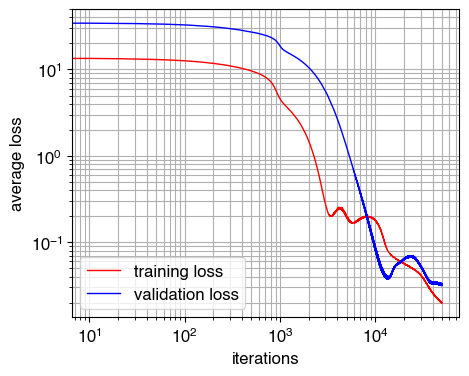

In [19]:
epoch = 0

X = []
T = []
V = []

min_avloss = float('inf')

for ii in range(n_iterations):

    # clear previous gradients
    
    optimizer.zero_grad()
    
    # set mode to training so that training specific 
    # operations such as dropout are enabled.
    
    model.train()

    # get a batch of data 
    
    x, y, jj = get_batch(train_x, train_y, n_batch, ii)     

    if jj == 0:
        epoch += 1
        
    f = model(x).reshape(y.shape)

    R = emprisk(f, y)
    
    R.backward()  # compute gradients of with respect to NN parameters

    optimizer.step()    # advance one step in the space of NN parameters

    if ii % n_step == 0:
           
        t_loss = validate(model, emprisk, train_x2, train_y2).detach()
        v_loss = validate(model, emprisk, valid_x,  valid_y).detach()

        print(f'\r|{epoch:9d}|{ii:9d}|{t_loss:9.3e}|{v_loss:9.3e}|', end='')

        X.append(ii)
        T.append(float(t_loss))
        V.append(float(v_loss))

        if v_loss < 0.95 * min_avloss:
            min_avloss = v_loss
            torch.save(model.state_dict(), MODELFILE)
        
print()

plot_loss_curve([X, T, V])

In [20]:
Z_test=19/50
N_test=36/25

input_array = torch.tensor([[23/25, 19/50]], dtype=torch.float).to(DEVICE)

model.eval()

with torch.no_grad():
    prediction = model(input_array).item()  # Get prediction as a scalar

print(f'Prediction for input {prediction}')


Prediction for input 3.4265177249908447


#### Creating a comparison for the entire data set

In [21]:
concatenated_df = pd.concat([df2013_selected, df2021_selected], ignore_index=True)
# Ensure the model is in evaluation mode
concatenated_df
# break
# model.eval()

# # Convert ['N_new', 'Z_new'] columns to a tensor
input_features = torch.tensor(concatenated_df[['N_new', 'Z_new']].to_numpy()).float().to(DEVICE)
# len(input_features)
# # Pass through the model and get predictions
with torch.no_grad():  # No need to track gradients for inference
    predictions = model(input_features).cpu().numpy().flatten()  # Ensure it's a flat array

# # Add the predictions as a new column in concatenated_df
concatenated_df['model_predictions'] = predictions
concatenated_df['R_exp-R_prd'] = concatenated_df['radius_val']-concatenated_df['model_predictions']

# # Display the updated DataFrame
# print(concatenated_df.head())
concatenated_df


,Z,symbol,A,N,N_new,Z_new,radius_val,radius_unc,model_predictions,R_exp-R_prd
0,0,n,1,1,0.04,0.00,-0.1149,0.0027,0.843649,-0.958549
1,1,H,1,0,0.00,0.02,0.8783,0.0086,1.000160,-0.121860
2,1,H,2,1,0.04,0.02,2.1421,0.0088,1.348180,0.793920
3,1,H,3,2,0.08,0.02,1.7591,0.0363,1.590558,0.168542
4,2,He,3,1,0.04,0.04,1.9661,0.0030,1.766884,0.199216
...,...,...,...,...,...,...,...,...,...,...
1034,87,Fr,204,117,4.68,1.74,5.5390,0.0183,5.398420,0.140580
1035,87,Fr,205,118,4.72,1.74,5.5476,0.0182,5.411288,0.136312
1036,87,Fr,206,119,4.76,1.74,5.5485,0.0182,5.423050,0.125450
1037,88,Ra,231,143,5.72,1.76,5.7850,0.0193,5.511401,0.273599


In [22]:
plt.scatter(concatenated_df['radius_val'], concatenated_df['model_predictions'])#, label='Actual Radius', color='blue', marker='o')

R_true= concatenated_df['radius_val'].to_numpy()
R_predi= concatenated_df['model_predictions'].to_numpy()

dr=R_true-R_predi

dr_exp= df['radius_unc'].to_numpy()

dr.std(), dr_exp.std()

(0.08513686205375096, 0.03639748226114586)

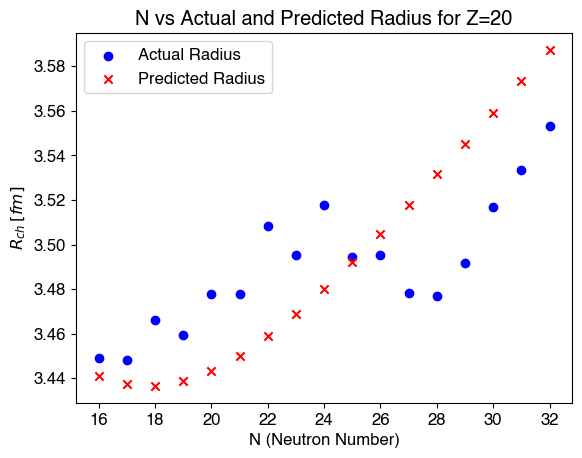

In [26]:
Z=20
df_filtered = concatenated_df[concatenated_df['Z'] == Z]


plt.scatter(df_filtered['N'], df_filtered['radius_val'], label='Actual Radius', color='blue', marker='o')

plt.scatter(df_filtered['N'], df_filtered['model_predictions'], label='Predicted Radius', color='red', marker='x')

plt.xlabel('N (Neutron Number)')
plt.ylabel(r'$R_{ch} \, [fm]$')
plt.title('N vs Actual and Predicted Radius for Z=%s'%Z)
plt.legend()
plt.show()


> FC Net II has been constructed
>
> Compared the std with experimental values and model predictions